<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: center; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
    Beta-Lactamase: classification_model
</div>

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Introduction</div>

This project proposed by [Data Professor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) aims to build models predicting molecules binding to the Beta-Lactamase protein. For the complete project description, see this [video](https://www.youtube.com/watch?v=_GtEgiWWyK4) on the [Data Professor](https://www.youtube.com/channel/UCV8e2g4IWQqK71bbzGDEI4Q) channel.
The EDA and data pre-processing were performed in the notebook [Beta-Lactamase_001_Data_Wrangling_and_EDA](https://www.kaggle.com/wguesdon/beta-lactamase-001-data-wrangling-and-eda/edit/run/83400192).  
This notebook contains the baseline classification model.

# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">I Initialization</div> 

In [1]:
###################
# I Initialization
###################

#+++++++++++++++
# Load libraries
#+++++++++++++++

import os
from pathlib import Path # for path in Windows and Unix
import zipfile
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

#+++++++++++++++++++
# Define Environment
#++++++++++++++++++

environemnt = 'kaggle'

#+++++++++++++++++++++++++++
# Define the working folders
#+++++++++++++++++++++++++++

# see https://careerkarma.com/blog/python-list-files-in-directory/
# See https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f

if environemnt == 'kaggle':
    project_data_folder = Path('/kaggle/input/beta-lactamase-001-data-wrangling-and-eda/')
if environemnt == 'local':
    project_data_folder = Path('/home/will/Documents//Python/Beta_lactamase/Data/')
if environemnt == 'colab':
    project_data_folder = Path('/content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/')
    
#++++++++++++++++++++++++
# Load the processed data
#++++++++++++++++++++++++

file_path = project_data_folder / 'beta-lactamase_filtered_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label,Name,...,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL1401836,COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC,=,79432.8,nM,Potency,4.10,Beta-lactamase AmpC,assay format,CHEMBL1401836,...,0,0,1,1,1,0,0,0,0,1
1,CHEMBL554891,Cl.c1ccc(C2CN3CCSC3=N2)cc1,=,631.0,nM,Potency,6.20,Beta-lactamase AmpC,assay format,CHEMBL554891,...,0,0,1,1,1,0,0,0,0,1
2,CHEMBL1519543,CCOc1ccc(CCNC(=O)Cn2ncn3c(cc4ccccc43)c2=O)cc1OCC,=,631.0,nM,Potency,6.20,Beta-lactamase AmpC,assay format,CHEMBL1519543,...,0,0,1,1,1,0,0,0,0,1
3,CHEMBL1401837,O=C(Nc1ccc2c(c1)OCO2)c1cc(C2CC2)on1,=,5623.4,nM,Potency,5.25,Beta-lactamase AmpC,assay format,CHEMBL1401837,...,0,0,1,1,1,0,0,0,0,1
4,CHEMBL2369239,CCCCCCOc1ccc(N2C(=O)CC(SC(=N)N/N=C(\C)c3cccs3)...,=,63095.7,nM,Potency,4.20,Beta-lactamase AmpC,assay format,CHEMBL2369239,...,0,0,1,1,1,0,0,0,0,1


# <div style="background-color:#0A0F29; font-family:'Poppins', cursive; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">II Baseline Model</div>

In [2]:
###################
# II Baseline Model
###################

#+++++++++++++++++++
# Feature enginering
#+++++++++++++++++++

# Drop content no useful for prediction
# canonical_smiles, standard_relation, standard_value, standard_units, 
# standard_type, target_pref_name, bao_label

columns_to_drop = ['canonical_smiles', 'standard_relation', 'standard_value', 'standard_units', 
                   'standard_type', 'target_pref_name', 'bao_label', 'Name', 'molecule_chembl_id']
df1 = df.drop(columns_to_drop, axis = 1)

# Recode pchembl_value	
# pChEMBL values <5 == 'Inactive' pChEMBL values > 6 == 'Active' pChEMBL values 5-6 == 'Intermediate'
# Inactive = 0
# Intermediate = 1
# Active = 2

def pchembl_value_encoding(pchembl_value):
    if pchembl_value < 5:
        return 'Inactive'
    elif pchembl_value > 5 and pchembl_value < 6:
        return 'Intermediate'
    else:
        return 'Active'

df1['pchembl_value_code'] = df1.apply(lambda row : pchembl_value_encoding(row['pchembl_value']), axis = 1)

df1 = df1.drop(['pchembl_value'], axis = 1)
df1.head()

,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,...,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307,pchembl_value_code
0,0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Inactive
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Active
2,1,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Active
3,0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Intermediate
4,1,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Inactive


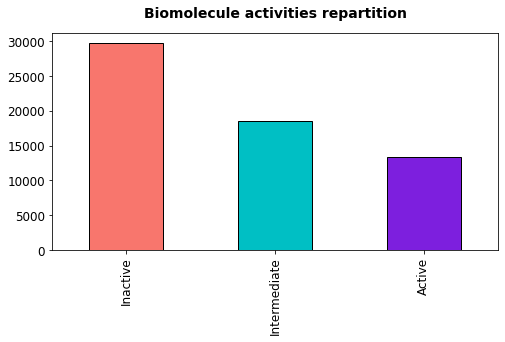

In [3]:
pchembl_value_code = df1.pchembl_value_code.value_counts()
pchembl_value_code.plot.bar(figsize=(8,4), color = ['#F8766D', '#00BFC4', '#7D1FDE'], ec='black')

plt.title('Biomolecule activities repartition', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [4]:
#++++++++++++++++++++
# Random Forest model
#++++++++++++++++++++

# see Basic Code Stencil (PRACTICAL) Data Science infinity
# see https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# see https://medium.com/@benfenison/gridsearching-a-random-forest-classifier-fc225609699c

# Split data into input and output objects
X = df1.drop(['pchembl_value_code'], axis = 1)
y = df1['pchembl_value_code']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

# Apply SMOTE resampling to correct for class unbalance
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

# Instanciate the grid search object
rf_grid = {"n_estimators" : [100, 150, 200, 250, 500],
           "max_depth" : [None , 3 , 5 , 10],
           "min_samples_split" : np.arange(2 , 20 ,4),
           "min_samples_leaf" : np.arange(1 , 20 ,4)}

gscv = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid = rf_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1
)

# Fit to data
gscv.fit(X_train, y_train)

# Get the best CV score
gscv.best_score_

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.5341253420224381

In [5]:
# Optimal parameters
gscv.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [6]:
# Create optimal model object
clf = gscv.best_estimator_

# Train the optimal model
# Train our model
clf.fit(X_train, y_train)

# Assess the model accuracy
# see https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case

y_pred = clf.predict(X_test)

# Accuracy
print('accuracy score:', accuracy_score(y_test, y_pred))

# Precision
print('precision score:', precision_score(y_test, y_pred, average="macro"))

# Recall score
print('recall score:', recall_score(y_test, y_pred, average="macro"))

# F1 score
print('F1 score:',f1_score(y_test, y_pred, average="macro"))

accuracy score: 0.3863949995941229
precision score: 0.36101676310444564
recall score: 0.36217562982144097
F1 score: 0.3605186337391899


In [7]:
# Feature importance
result = permutation_importance(clf, X_test, y_test, n_repeats = 10, random_state = 42)

permutation_importance= pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names, permutation_importance], axis = 1)
permutation_importance_summary.columns = ["input_variable", "feature_importance"]
permutation_importance_summary.sort_values(by = "feature_importance", inplace=True)

# List the 20 top features
permutation_importance_summary.head(20)

,input_variable,feature_importance
15,SubFP16,-0.003385
95,SubFP96,-0.002971
37,SubFP38,-0.002573
25,SubFP26,-0.001794
213,SubFP214,-0.001632
19,SubFP20,-0.001477
83,SubFP84,-0.001388
286,SubFP287,-0.001250
298,SubFP299,-0.000998
174,SubFP175,-0.000796
